In [186]:
import tensorflow as tf
from tensorflow import keras
from skimage import io
from skimage.io import imread_collection
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
import shutil
import os

## Fetch Data (Images)
We begin by fetching a dataset of 10,000 images from [thispersondoesnotexistcom](https://www.thispersondoesnotexist.com). We do so by requesting from the endpoint `thispersondoesnotexist.com/images` 10,000 (k) times.

#### Declare Paths & File Types

In [187]:
image_path = "./data/training"

In [188]:
current_img_type = "png"

#### Saving an image

In [189]:
def save_image(image, count):
        with open(f'{image_path}/img_{count}.{current_img_type}', 'wb') as f:
            f.write(image)

#### Scraping images from `thispersondoesnotexists.com`

In [190]:
def fetch_images(k: int, folder_name: str):
    """ 
    Fetch images from thispersondoesnotexist.com
    
    :param k: number of images to fetch
    :param folder_name: name of folder to save images to
    """
    if k < 1:
        return 0
    
    # Locals
    count = 0
    endpoint = 'image'
    url = f'https://thispersondoesnotexist.com/{endpoint}'
    while count < k:
        image = requests.get(url).content
        save_image(image)
        count += 1
        
        # A time.sleep(x) is recommended to avoid latency errors

If we'd like to scrape the images, simply call
```python
fetch_images(k=10_000, folder_name='training')
```

## Validating image
We should validate wether the image exists

#### Reading an Image

In [191]:
def read_image(folder_name:str, image_name:str, idx:int):
    return io.imread(f'{folder_name}/{image_name}.{current_img_type}')

#### Checking whether an images exists

In [192]:
def image_exists(folder_name:str) -> bool:
    """ 
    Check whether an image exists in folder_name
    
    :param folder_name: folder in which dataset images are located
    """
    try:
        # Default image 0
        image = read_image(image_path,'img_0', 0)
        return True
    except:
        print(f'Image "img_0.{current_img_type}" in {folder_name} not found')
        return False

## Showing a batch
We can see a random batch of images from the dataset

In [193]:
def show_batch(batch):
    
    # Default batch_size of 3
    images = np.random.randint(low=0, high=len(batch), size=9) # get random indices
    fig = plt.figure(figsize= (3, 3)) 
    fig, axs = plt.subplots(3,3, sharex=True, sharey=True)
    cnt = 0 
    for i in range(3):
        for j in range(3):
            axs[i, j].imshow(batch[images[cnt]]) # get image from batch at index 'i'
            cnt += 1
    plt.show()

### Image Attributes

#### Reading collection of images from folder

In [194]:
def read_collection(folder_name:str):
    return imread_collection(f'./{folder_name}/*.{current_img_type}')

We read and store the collection

In [195]:
collection = read_collection(image_path)

In [196]:
len(collection)

8892

<Figure size 216x216 with 0 Axes>

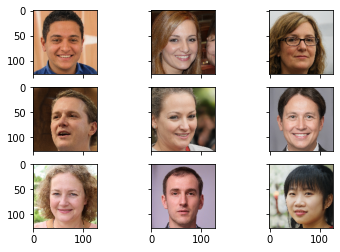

In [197]:
show_batch(collection)

In [198]:
collection[0].shape

(128, 128, 3)

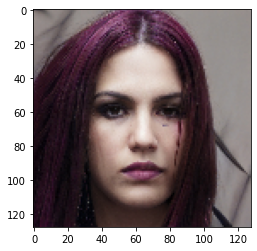

In [199]:
plt.imshow(collection[0])

### Resizing Images
As we can see, all images fetched are $w \times h \times c$, it is necessary we resize these into smaller dimensions to efficiently approach this DCGAN.

We import `CV2` to resize the images in `./images`

In [200]:
import cv2

We now resize every image in the `collection` and update them with given the new dimensions. All images in `collection` are named as their appropriate index in this list

In [201]:
def make_dir(folder_name: str):
    if not os.path.exists(f'./{folder_name}'):
        os.makedirs(folder_name)

In [202]:
def resize_image(image, size):
    resized_image = cv2.resize(image, dsize=size, interpolation=cv2.INTER_CUBIC)
    return Image.fromarray(resized_image)

In [203]:
def resize_collection(folder_name:str, file_name:str, collection):
    make_dir(folder_name)
        
    for i in range(len(collection)): 
        new_image = resize_image(collection[i], (128, 128)) 
        new_image.save(f'./{file_name}/img_{i}.png')

### Neural Network - 1.0
We begin by definning attributes. All images in the dataset are from [thispersondoesnotexistcom](https://www.thispersondoesnotexist.com), therefore all images are $1024 \times 1024$ with $3$ channels. However, our sizing may be $w \times h \times c$ if resized.

In [204]:
rows = collection[0].shape[0]
cols = collection[0].shape[1]
channels = collection[0].shape[2]

In [205]:
image_shape = (rows, cols, channels)

`z_dim` represents the dimenions of the noise vector to be inputed into the generator

In [206]:
image_shape

(128, 128, 3)

We first import libraries to be used

In [207]:
from keras.utils.vis_utils import plot_model
from keras.layers import Dense, Flatten, Reshape, Conv2DTranspose, UpSampling2D, Activation, Conv2D, BatchNormalization, UpSampling2D
from keras.layers import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

import time

In [208]:
z_dim = 128 

We implement the schematics for $G(z)$ for generating $1024 \times 1024$ images from [Marchesi, Marco. (2017). Megapixel Size Image Creation using Generative Adversarial Networks.](https://www.researchgate.net/publication/317300265_Megapixel_Size_Image_Creation_using_Generative_Adversarial_Networks), [Karras, Aila. (2018). Progressive Growing of GANs for Improved Quality Stability, and Variation.](https://arxiv.org/pdf/1710.10196.pdf). Our approach will be different. Assistance from these papers is taken.

#### Model to Image

In [209]:
def model_to_png(model, file_name:str):
    plot_model(model, to_file=f'{file_name}.png', show_shapes=True)

#### Generator 

In [210]:
def create_generator(z):
    model = Sequential()

    # Input Latent vector
    model.add(Dense(4*4*128, input_dim=z))
    model.add(Reshape((4, 4, 128)))
    
    # Conv
    model.add(Conv2DTranspose(128, kernel_size=4, strides=4, padding='valid'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(Conv2DTranspose(64, kernel_size=3, padding='same'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(Conv2DTranspose(32, kernel_size=3, strides=4, padding='same'))   
    model.add(BatchNormalization(momentum=0.5))
    model.add(Conv2DTranspose(16, kernel_size=3, padding='same'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(Conv2DTranspose(3, kernel_size=3, strides=2, padding='same'))    
    model.add(Activation('tanh'))
    return model

In [211]:
def test_generator(z_dim:int):
    gen = create_generator(z_dim)
    noise = tf.random.normal([1, z_dim])
    img = gen.predict(noise)
    img = tf.reshape(img, shape=(img.shape[1], img.shape[2], img.shape[3]))
    plt.imshow(img)
    plt.show()

To test it:

1/1 [==============================] - 0s 231ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


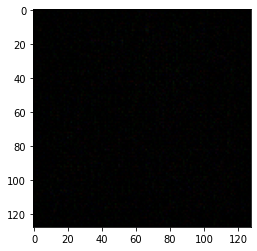

In [212]:
test_generator(z_dim)

#### Discriminator

In [213]:
def create_discriminator(img_shape):
    model = Sequential()
    model.add(Conv2D(3, kernel_size=1, padding='same', input_shape=img_shape))
    model.add(Conv2D(3, kernel_size=3, padding='same'))
    
    # Conv 1.0
    model.add(Conv2D(16, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # Conv 2.0
    model.add(Conv2D(32, kernel_size=2, strides=2, padding='valid'))
    model.add(LeakyReLU(alpha=0.2))

    # Conv 3.0
    model.add(Conv2D(64, kernel_size=2, strides=2, padding='valid'))
    model.add(LeakyReLU(alpha=0.2))

    # Conv 3.0
    model.add(Conv2D(128, kernel_size=2, strides=2, padding='valid'))
    model.add(LeakyReLU(alpha=0.2))

    # Conv 4.0
    model.add(Conv2D(128, kernel_size=2, strides=2, padding='valid'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, kernel_size=2, strides=2, padding='valid'))
    model.add(LeakyReLU(alpha=0.2))

    # Conv 5.0
    model.add(Conv2D(128, kernel_size=2, strides=2, padding='valid'))
    model.add(LeakyReLU(alpha=0.2))
              
    # Finalized
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

#### Set up (S) - 1.1 Create
We begin by initializing the discriminator and generator

In [214]:
generator = create_generator(z=z_dim)
discriminator = create_discriminator(img_shape=image_shape)

#### S - 1.2 Compile 
We now compile both models.

##### Generator Compile

In [215]:
generator.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=0.0020))

##### Discriminator Compile

In [216]:
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(learning_rate=0.0020),
                      metrics=['accuracy'])

#### S - 1.3 Disable Discriminator Training

In [217]:
discriminator.trainable = False

Alternatively, if we wanted to get the models as an image, we'd do:
```python
plot_model(discriminator, to_file='discriminator.png', show_shapes=True, show_dtype=True, show_layer_names=True)

plot_model(generator, to_file='generator.png', show_shapes=True, show_dtype=True, show_layer_names=True)
```

In [218]:
def GAN(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    
    return model

In [219]:
gan = GAN(generator, discriminator)
gan.compile(loss='binary_crossentropy', 
                  optimizer=Adam())

#### S - 1.4.1 Params

#### Time Stamping

In [220]:
def time_stamp(msg:str, time):
    print(f'{msg} - {time}')

#### Getting current time

In [221]:
def get_time():
    return time.ctime(time.time())

#### Training settings

In [222]:
iterations = 10000
batch_size = 45
sample_interval = 100
folder_name = 'model-02'

In [223]:
discriminator_losses = []
gan_losses = []

In [224]:
def train_gan(iteraions:int, batch_size:int, sample_interval:int, folder_name:str):
    data_images = read_collection(image_path)
    image_count = 0
    
    # Labels 
    time_stamp("Generating labels ...", get_time())
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))
    time_stamp("Finishing ...", get_time())
    
    make_dir(folder_name)
    make_dir(f'.{folder_name}/predictions')
    
    # Training
    for iteration in range(iterations):
        # time_stamp(f'Iteration {iteration} of {iterations}', get_time())
        
        # Collect batch
        random_indicies =  np.random.choice(len(data_images), size=batch_size, replace=False)
        real_image_batch = np.array([data_images[i] for i in random_indicies]) / 127.5 - 1.0 # rescale [-1,1]
        
        # Random batch of fake images
        z_fake = tf.random.normal([batch_size, 128])

        generated_images = generator.predict(z_fake)
        
        # Train Discriminator -> [Loss, Accuracy]
        discriminator_real_loss = discriminator.train_on_batch(real_image_batch, real_labels)       
        discriminator_fake_loss = discriminator.train_on_batch(generated_images, fake_labels)
        
        # Get Discriminator loss and accuracy
        discriminator_loss, accuracy = 0.5 * np.add(discriminator_real_loss, discriminator_fake_loss)
        
        # Train Generator
        z_fake = tf.random.normal([batch_size, 128])
        generated_images = generator.predict(z_fake)
        
        
        # Get Generator loss and accuracy
        gan_loss = gan.train_on_batch(z_fake, real_labels)
        
        discriminator_losses.append(discriminator_loss)
        gan_losses.append(gan_loss)
        # Progress output
        if (iteration + 1) % sample_interval == 0:
            print("Iteration %d [D loss: %f, acc.:%.2f%%] [G loss: %f]" % (iteration + 1, discriminator_loss, 100.0* accuracy, gan_loss))
            
            # Generate random images
            z_generated = tf.random.normal([3*3, 128])
            generate_images = generator.predict(z_generated)
            generate_images = 0.5 * generate_images + 0.5
            
            # Plot
            fig = plt.figure(figsize= (3, 3)) 
            fig, axs = plt.subplots(3, 3, sharex=True, sharey=True)
            cnt = 0 
            for i in range(3):
                for j in range(3):
                    axs[i, j].imshow(generate_images[cnt]) # get image from batch at index 'i'
                    cnt += 1
            plt.savefig(f'.{folder_name}/predictions/iteration{image_count}-gan.png')
            image_count += 1
            plt.show()
    generator.save(f'.{folder_name}/generator')
    discriminator.save(f'.{folder_name}/discriminator')
    gan.save(f'.{folder_name}/gan')

#### Training the network
```python
train_gan(iterations, batch_size, sample_interval)
```

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
train_gan(iterations, batch_size, sample_interval, folder_name)

In [ ]:
plt.plot(gan_losses)
plt.show()

In [ ]:
plt.plot(discriminator_losses)

In [ ]:
fake_image_01 = tf.random.normal([1, 128], mean=0, stddev=1)

In [ ]:
fake_gen_image_01 = generator.predict(fake_image_01)

In [ ]:
fake_gen_image_01 = 0.5 * fake_gen_image_01 + 0.5

In [ ]:
plt.imshow(fake_gen_image_01[0, :, :, :])